In [3]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

from torch.utils.data.sampler import SubsetRandomSampler

## Define Neural Network class


In [4]:
class NeuralNetwork(nn.Module):
  def __init__(self):
    super(NeuralNetwork,self).__init__()

    self.fc1 = nn.Linear(784,300,bias=False)
    self.fc2 = nn.Linear(300,200,bias=False)
    self.fc3 = nn.Linear(200,10,bias=False)
    self.sigmoid = nn.Sigmoid()

  def forward(self,x):
    x = x.view(-1, 28 * 28)
    x = self.sigmoid(self.fc1(x))
    x = self.fc2(x)
    x = self.fc3(x)

    
    return x





## Get MNIST dataset


In [5]:
transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
        ])

mnist_train = datasets.MNIST('../data', train=True, download=True,
                    transform=transform)
mnist_test = datasets.MNIST('../data', train=False, download=True,
                    transform=transform)



In [6]:
valid_ratio = 0.2
train_data_len = len(mnist_train)
indices = list(range(train_data_len))
np.random.shuffle(indices)
train_valid_split = int(np.floor(valid_ratio * train_data_len))
train_index, valid_index = indices[train_valid_split:], indices[:train_valid_split]



## Initialize dataloaders


In [7]:
train_sampler = SubsetRandomSampler(train_index)
valid_sampler = SubsetRandomSampler(valid_index)
# prepare data loaders
train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=64,  sampler=train_sampler)
valid_loader = torch.utils.data.DataLoader(mnist_train, batch_size=64, sampler=valid_sampler)
test_loader = torch.utils.data.DataLoader(mnist_test,batch_size=64)


In [8]:
def compute_accuracy(output, ground_truth):
    class_correct = 0
    class_total = 0
    batch_size = output.size(0)
    _, prediction = torch.max(output, 1)
    # compare predictions to true label
    correct = np.squeeze(prediction.eq(ground_truth.data.view_as(prediction)))
    # calculate test accuracy for each object class
    for i in range(batch_size):
        label = ground_truth.data[i]
        class_correct += correct[i].item()
        class_total += 1
    return class_correct, class_total

## Initialize Model and Optimizer


#SGD

In [9]:
model = NeuralNetwork().cuda()
optimizer = optim.SGD(model.parameters(), lr=0.01)

## Training Loop

In [10]:
train_loss_list = []
train_loss_epoch_list = []

valid_loss_list = []
valid_loss_epoch_list = []
train_accuracy_list = []
valid_accuracy_list = []

for epoch in range(0, 30):
    train_loss = 0.0
    valid_loss = 0.0
    criterion = nn.CrossEntropyLoss()
    model.train()
    total_train_correct = 0
    total_train = 0
    total_valid_correct = 0
    total_valid = 0

    for batch_idx, batch in enumerate(train_loader):
        
        input, ground_truth = batch
        batch_size = input.size(0)
        input = input.cuda()
        ground_truth = ground_truth.cuda()
        
        optimizer.zero_grad()
        output = model(input)
        
        
        loss = criterion(output, ground_truth)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*input.size(0)
        train_correct, train_size = compute_accuracy(output, ground_truth)
        total_train_correct += train_correct
        total_train += train_size
        train_loss_list.append(loss)

    if epoch%5 == 0:
      model.eval()  # prep model for evaluation
      for batch_idx, batch in enumerate(valid_loader):
          val_input, ground_truth = batch
          val_input = val_input.cuda()
          ground_truth = ground_truth.cuda()
          
          # forward pass: compute predicted outputs by passing inputs to the model
          output = model(val_input)
          # calculate the loss
          loss = criterion(output,ground_truth)
          # update running validation loss 
          valid_loss += loss.item() * input.size(0)
          valid_correct, valid_size = compute_accuracy(output, ground_truth)
          total_valid_correct += valid_correct
          total_valid += valid_size
          valid_loss_list.append(loss)
      valid_loss = valid_loss/len(valid_loader.dataset)
      valid_accuracy = np.sum(total_valid_correct) / np.sum(total_valid)
      valid_loss_epoch_list.append(valid_loss)   
      valid_accuracy_list.append(valid_accuracy)

    

    train_loss = train_loss/len(train_loader.dataset)
    train_accuracy = np.sum(total_train_correct) / np.sum(total_train)
    train_loss_epoch_list.append(train_loss)
    train_accuracy_list.append(train_accuracy)
    


    print("********************************************************************")
    print("Epoch "+str(epoch))
    print("Train loss: "+str(train_loss))
    print("Train accuracy: "+str(train_accuracy))
    if epoch%5 == 0: 
      print("Valid loss: "+str(valid_loss))
      print("Valid Accuracy: "+str(valid_accuracy))
    
    print("********************************************************************")



torch.save(model.state_dict(), "mnist_mlp.pt")

********************************************************************
Epoch 0
Train loss: 1.2735712157567343
Train accuracy: 0.6204375
Valid loss: 0.16952029863993326
Valid Accuracy: 0.8074166666666667
********************************************************************
********************************************************************
Epoch 1
Train loss: 0.4942442518234253
Train accuracy: 0.8452291666666667
********************************************************************
********************************************************************
Epoch 2
Train loss: 0.3468940513134003
Train accuracy: 0.8814166666666666
********************************************************************
********************************************************************
Epoch 3
Train loss: 0.2986957718849182
Train accuracy: 0.8948125
********************************************************************
********************************************************************
Epoch 4
Train loss: 0.274198158057

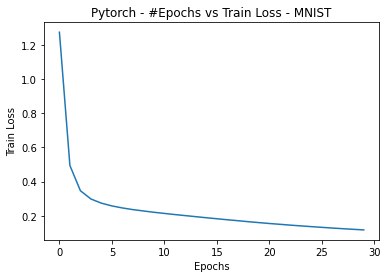

In [11]:
plt.plot(np.arange(0,len(train_loss_epoch_list)),train_loss_epoch_list)
plt.title("Pytorch - #Epochs vs Train Loss - MNIST")
plt.xlabel("Epochs")
plt.ylabel("Train Loss")
plt.savefig("pytorch_train_loss.pdf")

In [14]:
valid_loss_epoch_list

[0.16952029863993326,
 0.06326849163373312,
 0.0540790207862854,
 0.04733386443853378,
 0.04134359220266342,
 0.036492734253406524]

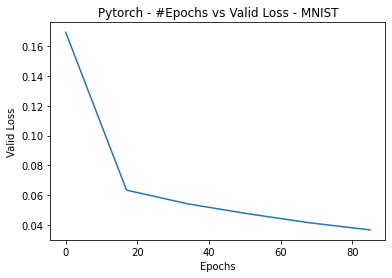

In [16]:
plt.plot(np.arange(0,100,17),valid_loss_epoch_list)
plt.title("Pytorch - #Epochs vs Valid Loss - MNIST")
plt.xlabel("Epochs")
plt.ylabel("Valid Loss")
plt.savefig("pytorch_valid_loss.pdf")

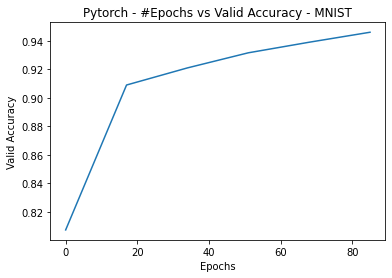

In [17]:
plt.plot(np.arange(0,100,17),valid_accuracy_list)
plt.title("Pytorch - #Epochs vs Valid Accuracy - MNIST")
plt.xlabel("Epochs")
plt.ylabel("Valid Accuracy")
plt.savefig("pytorch_valid_accuracy.pdf")

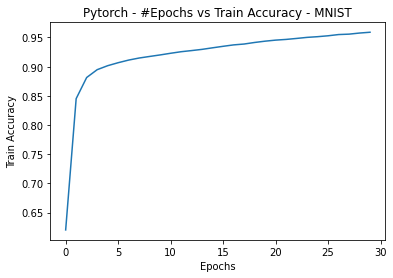

In [18]:
plt.plot(np.arange(0,len(train_loss_epoch_list)),train_accuracy_list)
plt.title("Pytorch - #Epochs vs Train Accuracy - MNIST")
plt.xlabel("Epochs")
plt.ylabel("Train Accuracy")
plt.savefig("pytorch_train_accuracy.pdf")

## Evaluate on Test Set

In [19]:
model.eval()  # prep model for evaluation
total_test = 0
total_test_correct = 0
test_loss = 0.0

for batch_idx, batch in enumerate(test_loader):
    test_input, ground_truth = batch
    test_input = test_input.cuda()
    ground_truth = ground_truth.cuda()
    
    
    output = model(test_input)
    loss = criterion(output,ground_truth)
    test_loss += loss.item() * input.size(0)
    test_correct, test_size = compute_accuracy(output, ground_truth)
    total_test_correct += test_correct
    total_test += test_size
    
test_loss = test_loss/len(test_loader.dataset)
test_accuracy = np.sum(total_test_correct) / np.sum(total_test)


In [20]:
print(test_loss)

0.15781175110936166


In [21]:
print(test_accuracy)

0.9542


#Initialize Weights to Zeros


In [22]:
def init_weights_zero(m):
    if type(m) == nn.Linear:
        torch.nn.init.constant_(m.weight.data,val=0.0)

In [23]:
model = NeuralNetwork().cuda()
model.apply(init_weights_zero)
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [24]:
print(model.fc1.weight.data)

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0')


In [26]:
train_loss_list = []
train_loss_epoch_list = []

valid_loss_list = []
valid_loss_epoch_list = []
train_accuracy_list = []
valid_accuracy_list = []

for epoch in range(0, 30):
    train_loss = 0.0
    valid_loss = 0.0
    criterion = nn.CrossEntropyLoss()
    model.train()
    total_train_correct = 0
    total_train = 0
    total_valid_correct = 0
    total_valid = 0

    for batch_idx, batch in enumerate(train_loader):
        
        input, ground_truth = batch
        batch_size = input.size(0)
        input = input.cuda()
        ground_truth = ground_truth.cuda()
        
        optimizer.zero_grad()
        output = model(input)
        
        
        loss = criterion(output, ground_truth)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*input.size(0)
        train_correct, train_size = compute_accuracy(output, ground_truth)
        total_train_correct += train_correct
        total_train += train_size
        train_loss_list.append(loss)

    if epoch%5 == 0:
      model.eval()  # prep model for evaluation
      for batch_idx, batch in enumerate(valid_loader):
          val_input, ground_truth = batch
          val_input = val_input.cuda()
          ground_truth = ground_truth.cuda()
          
          # forward pass: compute predicted outputs by passing inputs to the model
          output = model(val_input)
          # calculate the loss
          loss = criterion(output,ground_truth)
          # update running validation loss 
          valid_loss += loss.item() * input.size(0)
          valid_correct, valid_size = compute_accuracy(output, ground_truth)
          total_valid_correct += valid_correct
          total_valid += valid_size
          valid_loss_list.append(loss)
      valid_loss = valid_loss/len(valid_loader.dataset)
      valid_accuracy = np.sum(total_valid_correct) / np.sum(total_valid)
      valid_loss_epoch_list.append(valid_loss)   
      valid_accuracy_list.append(valid_accuracy)

    

    train_loss = train_loss/len(train_loader.dataset)
    train_accuracy = np.sum(total_train_correct) / np.sum(total_train)
    train_loss_epoch_list.append(train_loss)
    train_accuracy_list.append(train_accuracy)
    


    print("********************************************************************")
    print("Epoch "+str(epoch))
    print("Train loss: "+str(train_loss))
    print("Train accuracy: "+str(train_accuracy))
    if epoch%5 == 0: 
      print("Valid loss: "+str(valid_loss))
      print("Valid Accuracy: "+str(valid_accuracy))
    
    print("********************************************************************")



torch.save(model.state_dict(), "mnist_zero.pt")

********************************************************************
Epoch 0
Train loss: 1.8420679092407226
Train accuracy: 0.09835416666666667
Valid loss: 0.4617450225830078
Valid Accuracy: 0.10016666666666667
********************************************************************
********************************************************************
Epoch 1
Train loss: 1.8420679092407226
Train accuracy: 0.09835416666666667
********************************************************************
********************************************************************
Epoch 2
Train loss: 1.8420679092407226
Train accuracy: 0.09835416666666667
********************************************************************
********************************************************************
Epoch 3
Train loss: 1.8420679092407226
Train accuracy: 0.09835416666666667
********************************************************************
********************************************************************
Epoch 4
Trai

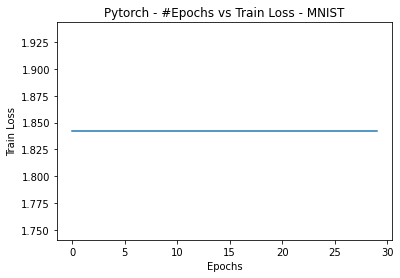

In [27]:
plt.plot(np.arange(0,len(train_loss_epoch_list)),train_loss_epoch_list)
plt.title("Pytorch - #Epochs vs Train Loss - MNIST")
plt.xlabel("Epochs")
plt.ylabel("Train Loss")

plt.savefig("pytorch_zero_train_loss.pdf")

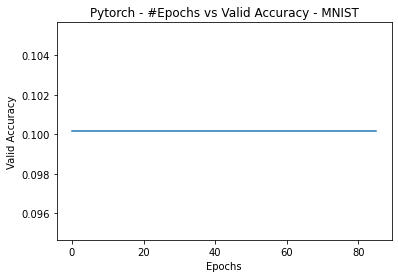

In [30]:
plt.plot(np.arange(0,100,17),valid_accuracy_list)
plt.title("Pytorch - #Epochs vs Valid Accuracy - MNIST")
plt.xlabel("Epochs")
plt.ylabel("Valid Accuracy")
plt.savefig("pytorch_zero_valid_accuracy.pdf")

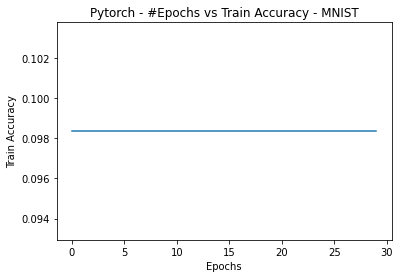

In [32]:
plt.plot(np.arange(0,30),train_accuracy_list)
plt.title("Pytorch - #Epochs vs Train Accuracy - MNIST")
plt.xlabel("Epochs")
plt.ylabel("Train Accuracy")
plt.savefig("pytorch_zero_train_accuracy.pdf")

In [33]:
model.eval()  # prep model for evaluation
total_test = 0
total_test_correct = 0
test_loss = 0.0

for batch_idx, batch in enumerate(test_loader):
    test_input, ground_truth = batch
    test_input = test_input.cuda()
    ground_truth = ground_truth.cuda()
    
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(test_input)
    # calculate the loss
    loss = criterion(output,ground_truth)
    # update running validation loss 
    test_loss += loss.item() * input.size(0)
    test_correct, test_size = compute_accuracy(output, ground_truth)
    total_test_correct += test_correct
    total_test += test_size
    
test_loss = test_loss/len(test_loader.dataset)
test_accuracy = np.sum(total_test_correct) / np.sum(total_test)


In [34]:
print(test_loss)

2.3136372970581056


In [35]:
print(test_accuracy)

0.098


#Initialize weights Randomly between -1 and 1

In [37]:
def init_weights_zero(m):
    if type(m) == nn.Linear:
        m.weight.data.uniform_(-1,1)
        

In [38]:
model = NeuralNetwork().cuda()
model.apply(init_weights_zero)
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [39]:
print(model.fc1.weight.data)

tensor([[-0.4524,  0.3183,  0.4898,  ..., -0.7881,  0.2775,  0.2531],
        [ 0.5349, -0.5030,  0.1148,  ..., -0.0783,  0.3183, -0.1846],
        [-0.1632, -0.4170,  0.2191,  ..., -0.2495, -0.6436,  0.4796],
        ...,
        [-0.5019,  0.4783,  0.1737,  ...,  0.2497,  0.8971,  0.0754],
        [-0.0470, -0.4230, -0.5611,  ...,  0.5602,  0.2503, -0.8188],
        [ 0.2053, -0.8059, -0.2310,  ...,  0.8618, -0.9209,  0.6858]],
       device='cuda:0')


In [40]:
train_loss_list = []
train_loss_epoch_list = []

valid_loss_list = []
valid_loss_epoch_list = []
train_accuracy_list = []
valid_accuracy_list = []

for epoch in range(0, 30):
    train_loss = 0.0
    valid_loss = 0.0
    criterion = nn.CrossEntropyLoss()
    model.train()
    total_train_correct = 0
    total_train = 0
    total_valid_correct = 0
    total_valid = 0

    for batch_idx, batch in enumerate(train_loader):
        
        input, ground_truth = batch
        batch_size = input.size(0)
        input = input.cuda()
        ground_truth = ground_truth.cuda()
        
        optimizer.zero_grad()
        output = model(input)
        
        
        loss = criterion(output, ground_truth)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*input.size(0)
        train_correct, train_size = compute_accuracy(output, ground_truth)
        total_train_correct += train_correct
        total_train += train_size
        train_loss_list.append(loss)

    if epoch%5 == 0:
      model.eval()  # prep model for evaluation
      for batch_idx, batch in enumerate(valid_loader):
          val_input, ground_truth = batch
          val_input = val_input.cuda()
          ground_truth = ground_truth.cuda()
          
          # forward pass: compute predicted outputs by passing inputs to the model
          output = model(val_input)
          # calculate the loss
          loss = criterion(output,ground_truth)
          # update running validation loss 
          valid_loss += loss.item() * input.size(0)
          valid_correct, valid_size = compute_accuracy(output, ground_truth)
          total_valid_correct += valid_correct
          total_valid += valid_size
          valid_loss_list.append(loss)
      valid_loss = valid_loss/len(valid_loader.dataset)
      valid_accuracy = np.sum(total_valid_correct) / np.sum(total_valid)
      valid_loss_epoch_list.append(valid_loss)   
      valid_accuracy_list.append(valid_accuracy)

    

    train_loss = train_loss/len(train_loader.dataset)
    train_accuracy = np.sum(total_train_correct) / np.sum(total_train)
    train_loss_epoch_list.append(train_loss)
    train_accuracy_list.append(train_accuracy)
    


    print("********************************************************************")
    print("Epoch "+str(epoch))
    print("Train loss: "+str(train_loss))
    print("Train accuracy: "+str(train_accuracy))
    if epoch%5 == 0: 
      print("Valid loss: "+str(valid_loss))
      print("Valid Accuracy: "+str(valid_accuracy))
    
    print("********************************************************************")



torch.save(model.state_dict(), "mnist_random.pt")

********************************************************************
Epoch 0
Train loss: 5.862277214813233
Train accuracy: 0.7318125
Valid loss: 0.6669125602722168
Valid Accuracy: 0.8364166666666667
********************************************************************
********************************************************************
Epoch 1
Train loss: 2.124924057976405
Train accuracy: 0.8557083333333333
********************************************************************
********************************************************************
Epoch 2
Train loss: 1.4661830997327963
Train accuracy: 0.88025
********************************************************************
********************************************************************
Epoch 3
Train loss: 1.1250264423290888
Train accuracy: 0.8950208333333334
********************************************************************
********************************************************************
Epoch 4
Train loss: 0.9075602598298651


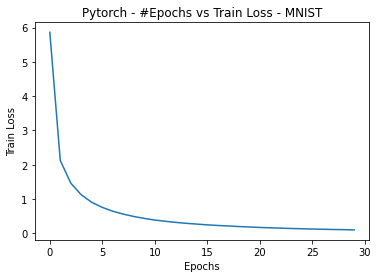

In [41]:
plt.plot(np.arange(0,len(train_loss_epoch_list)),train_loss_epoch_list)
plt.title("Pytorch - #Epochs vs Train Loss - MNIST")
plt.xlabel("Epochs")
plt.ylabel("Train Loss")
plt.savefig("pytorch_random_train_loss.pdf")

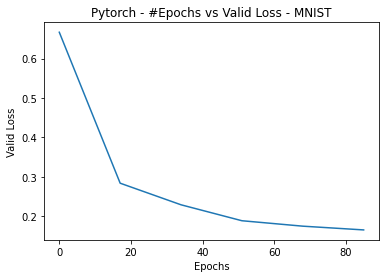

In [45]:
plt.plot(np.arange(0,100,17),valid_loss_epoch_list)
plt.title("Pytorch - #Epochs vs Valid Loss - MNIST")
plt.xlabel("Epochs")
plt.ylabel("Valid Loss")
plt.savefig("pytorch_random_val_loss.pdf")

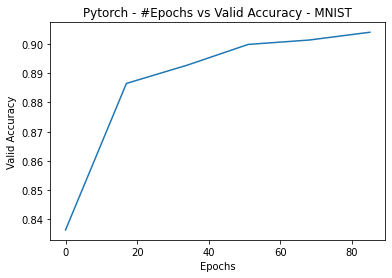

In [46]:
plt.plot(np.arange(0,100,17),valid_accuracy_list)
plt.title("Pytorch - #Epochs vs Valid Accuracy - MNIST")
plt.xlabel("Epochs")
plt.ylabel("Valid Accuracy")
plt.savefig("pytorch_random_valid_accuracy.pdf")

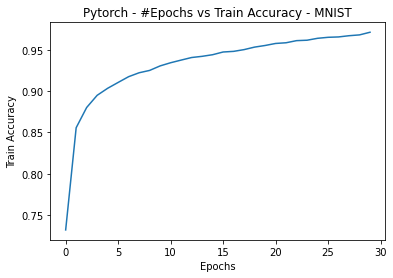

In [49]:
plt.plot(np.arange(0,30),train_accuracy_list)
plt.title("Pytorch - #Epochs vs Train Accuracy - MNIST")
plt.xlabel("Epochs")
plt.ylabel("Train Accuracy")
plt.savefig("pytorch_random_train_accuracy.pdf")

In [56]:
model.eval()  # prep model for evaluation
total_test = 0
total_test_correct = 0
test_loss = 0.0

for batch_idx, batch in enumerate(test_loader):
    test_input, ground_truth = batch
    test_input = test_input.cuda()
    ground_truth = ground_truth.cuda()
    
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(test_input)
    # calculate the loss
    loss = criterion(output,ground_truth)
    # update running validation loss 
    test_loss += loss.item() * input.size(0)
    test_correct, test_size = compute_accuracy(output, ground_truth)
    total_test_correct += test_correct
    total_test += test_size
    
test_loss = test_loss/len(test_loader.dataset)
test_accuracy = np.sum(total_test_correct) / np.sum(total_test)


In [57]:
print(test_loss)

0.7991937242200831


In [58]:
print(test_accuracy)

0.9041
